In [1]:
# Setup path to import src
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.utils.cds_plotter import CDSPlotter

In [2]:
from src.utils import config
# Example usage with new paths:
# plotter = CDSPlotter()
# plotter.load_data('GARCH', config.OUTPUT_DIR / 'cds_spreads_garch_mc.csv')

# CDS Spread Visualization

This notebook demonstrates how to use the `CDSPlotter` class to visualize CDS spreads from different models.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import importlib
from src.utils import cds_plotter

# Force reload to pick up changes
importlib.reload(cds_plotter)
from src.utils.cds_plotter import CDSPlotter

In [ ]:
# Initialize the plotter
plotter = CDSPlotter()

# Load the data using config paths
from src.utils import config

# Check if files exist before loading
garch_file = config.OUTPUT_DIR / 'cds_spreads_garch_mc_all_firms.csv'
rs_file = config.OUTPUT_DIR / 'cds_spreads_regime_switching_mc_all_firms.csv'
ms_garch_file = config.OUTPUT_DIR / 'cds_spreads_ms_garch_mc_all_firms.csv'

if garch_file.exists():
    plotter.load_data('GARCH', garch_file)
else:
    print(f"Warning: {garch_file} not found.")

if rs_file.exists():
    plotter.load_data('Regime Switching', rs_file)
else:
    print(f"Warning: {rs_file} not found.")
    
if ms_garch_file.exists():
    plotter.load_data('MS-GARCH', ms_garch_file)
else:
    print(f"Warning: {ms_garch_file} not found.")

Loading data for GARCH from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_garch_mc_all_firms.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 127908 rows for GARCH.
Loading data for Regime Switching from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_regime_switching_mc_all_firms.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 127908 rows for Regime Switching.
Loading data for MS-GARCH from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_ms_garch_mc_all_firms.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 127908 rows for MS-GARCH.


## 1. GARCH Model Results
Visualizing the term structure of CDS spreads over time for the GARCH model.

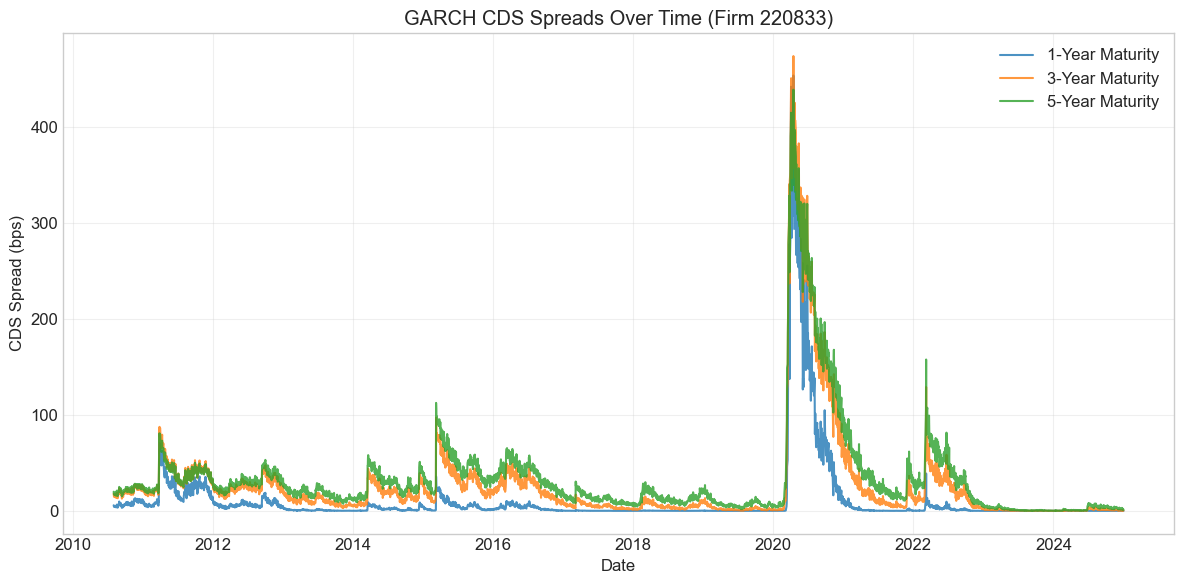

In [6]:
# Plot for firm 14447 
plotter.plot_spreads_over_time('GARCH', gvkey=220833, maturities=[1, 3, 5])

## 2. Regime Switching Model Results
Visualizing the term structure of CDS spreads over time for the Regime Switching model.

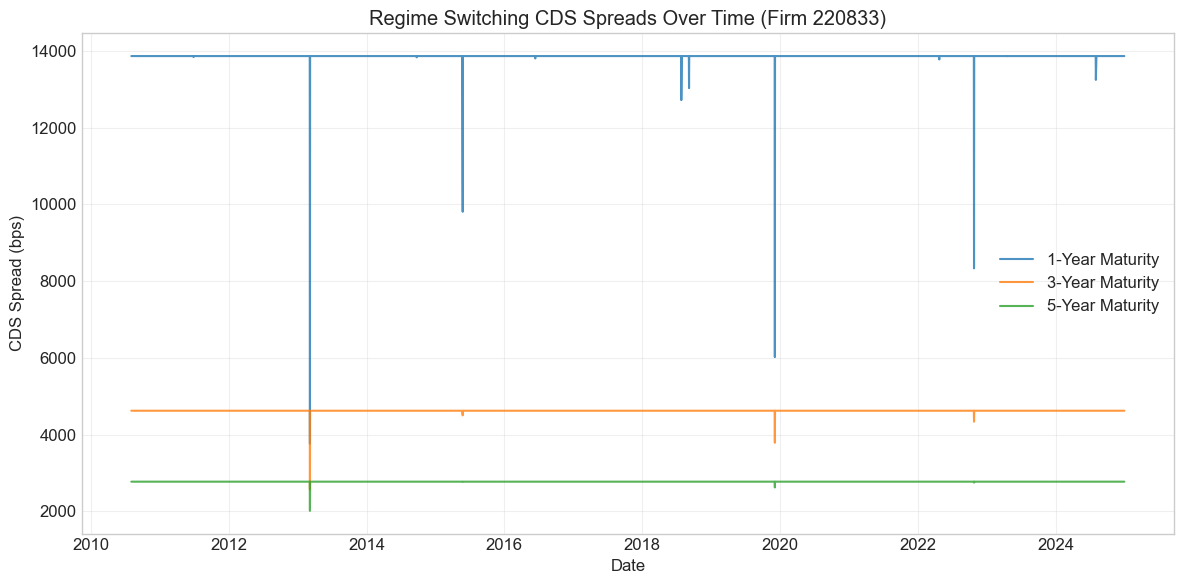

In [7]:
plotter.plot_spreads_over_time('Regime Switching', gvkey=220833, maturities=[1, 3, 5])

## 3. Model Comparison
Comparing the 5-year CDS spread estimates between models.

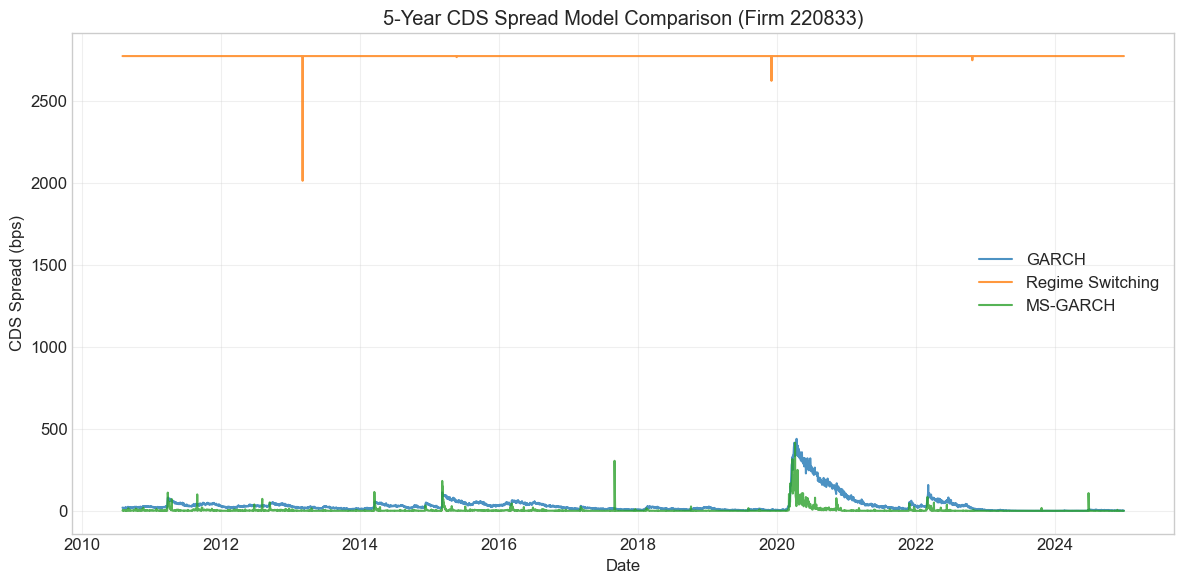

In [8]:
plotter.plot_model_comparison(gvkey=220833, maturity=5, models=['GARCH', 'Regime Switching', 'MS-GARCH'])

## 4. Average Spreads Across All Firms
Visualizing the average CDS spreads for all firms in the dataset (GARCH model).

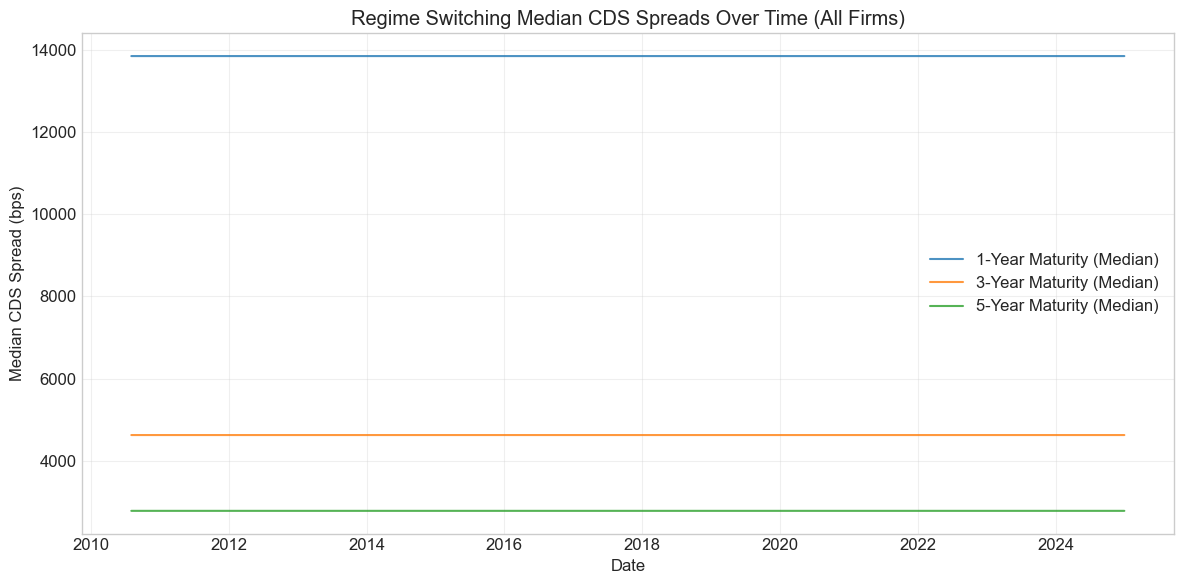

In [13]:
plotter.plot_average_spreads_over_time('Regime Switching', maturities=[1, 3, 5])

## 5. Regime Switching Model Diagnostics

**Note:** The cells in this section must be run in sequence from top to bottom.

Investigating the regime switching model issue (for debugging purposes).

In [ ]:
# Import libraries for diagnostic analysis
import pandas as pd
import numpy as np

# Define the firm to analyze (Firm 220833 was shown in the plot)
firm_id = 220833

In [ ]:
# Load the regime switching Monte Carlo results
mc_rs = pd.read_csv(config.OUTPUT_DIR / 'daily_monte_carlo_regime_switching_results.csv')
mc_rs['date'] = pd.to_datetime(mc_rs['date'])

# Load CDS spreads
cds_rs = pd.read_csv(config.OUTPUT_DIR / 'cds_spreads_regime_switching_mc_all_firms.csv')
cds_rs['date'] = pd.to_datetime(cds_rs['date'])

# Check firm 220833 specifically
firm_mc = mc_rs[mc_rs['gvkey'] == firm_id].copy()
firm_cds = cds_rs[cds_rs['gvkey'] == firm_id].copy()

print("Monte Carlo Results for Firm 220833:")
print(f"Number of observations: {len(firm_mc)}")
print(f"\nIntegrated Variance Statistics:")
print(firm_mc['rs_integrated_variance'].describe())
print(f"\nMean Daily Volatility:")
print(firm_mc['rs_mean_daily_volatility'].describe())
print(f"\nSample of first 10 rows:")
print(firm_mc[['date', 'rs_integrated_variance', 'rs_mean_daily_volatility']].head(10))

In [14]:
# Let's check the regime switching parameters to see what the returns look like
regime_params = pd.read_csv(config.OUTPUT_DIR / 'regime_switching_parameters.csv')
firm_params = regime_params[regime_params['gvkey'] == firm_id]

print("="*80)
print(f"REGIME SWITCHING PARAMETERS FOR FIRM {firm_id}")
print("="*80)
print(f"\nRegime 0 (Low Vol):")
print(f"  Mean: {firm_params['regime_0_mean'].values[0]:.6f}")
print(f"  AR(1): {firm_params['regime_0_ar'].values[0]:.6f}")
print(f"  Volatility: {firm_params['regime_0_vol'].values[0]:.6f}")
print(f"\nRegime 1 (High Vol):")
print(f"  Mean: {firm_params['regime_1_mean'].values[0]:.6f}")
print(f"  AR(1): {firm_params['regime_1_ar'].values[0]:.6f}")
print(f"  Volatility: {firm_params['regime_1_vol'].values[0]:.6f}")

print("\n" + "="*80)
print("KEY QUESTION: Are these DAILY returns or something else?")
print("="*80)
print("\nIn GARCH model:")
print("  - firm_daily_returns = firm_daily_vols * z_innovations")
print("  - Where z_innovations ~ N(0,1)")
print("  - So returns are centered at 0")
print("\nIn Regime Switching model:")
print("  - r_curr = mu + ar * r_prev + sigma * z")
print("  - Returns include mean (mu) and AR(1) component!")
print("  - This could be the issue if mu or AR are too large")

REGIME SWITCHING PARAMETERS FOR FIRM 220833

Regime 0 (Low Vol):
  Mean: -0.026855
  AR(1): 0.000000
  Volatility: 1.181569

Regime 1 (High Vol):
  Mean: 0.033810
  AR(1): 0.000000
  Volatility: 0.538086

KEY QUESTION: Are these DAILY returns or something else?

In GARCH model:
  - firm_daily_returns = firm_daily_vols * z_innovations
  - Where z_innovations ~ N(0,1)
  - So returns are centered at 0

In Regime Switching model:
  - r_curr = mu + ar * r_prev + sigma * z
  - Returns include mean (mu) and AR(1) component!
  - This could be the issue if mu or AR are too large


In [15]:
# Check all firms' regime switching parameters
print("="*80)
print("REGIME SWITCHING VOLATILITIES - ALL FIRMS")
print("="*80)
print("\nRegime 0 Volatility Statistics:")
print(regime_params['regime_0_vol'].describe())
print("\nRegime 1 Volatility Statistics:")
print(regime_params['regime_1_vol'].describe())

print("\n" + "="*80)
print("COMPARISON WITH DAILY VOLATILITY EXPECTATIONS")
print("="*80)
print("\nFor daily returns, we'd expect volatility around:")
print(f"  - Annual vol 20% → Daily vol = 0.20/sqrt(252) = {0.20/np.sqrt(252):.6f}")
print(f"  - Annual vol 50% → Daily vol = 0.50/sqrt(252) = {0.50/np.sqrt(252):.6f}")
print(f"  - Annual vol 100% → Daily vol = 1.00/sqrt(252) = {1.00/np.sqrt(252):.6f}")

print("\n" + "="*80)
print("HYPOTHESIS: Regime switching volatilities might be ANNUALIZED")
print("="*80)
print(f"\nIf we divide by sqrt(252):")
print(f"  Regime 0: {firm_params['regime_0_vol'].values[0]:.6f} → {firm_params['regime_0_vol'].values[0]/np.sqrt(252):.6f}")
print(f"  Regime 1: {firm_params['regime_1_vol'].values[0]:.6f} → {firm_params['regime_1_vol'].values[0]/np.sqrt(252):.6f}")
print("\nThese would be reasonable daily volatilities!")

REGIME SWITCHING VOLATILITIES - ALL FIRMS

Regime 0 Volatility Statistics:
count      34.000000
mean      193.656638
std       656.526741
min         0.291350
25%         1.022604
50%         1.203972
75%         1.709145
max      2978.549095
Name: regime_0_vol, dtype: float64

Regime 1 Volatility Statistics:
count     34.000000
mean       9.338401
std       50.447939
min        0.092059
25%        0.412503
50%        0.621613
75%        0.928681
max      294.837346
Name: regime_1_vol, dtype: float64

COMPARISON WITH DAILY VOLATILITY EXPECTATIONS

For daily returns, we'd expect volatility around:
  - Annual vol 20% → Daily vol = 0.20/sqrt(252) = 0.012599
  - Annual vol 50% → Daily vol = 0.50/sqrt(252) = 0.031497
  - Annual vol 100% → Daily vol = 1.00/sqrt(252) = 0.062994

HYPOTHESIS: Regime switching volatilities might be ANNUALIZED

If we divide by sqrt(252):
  Regime 0: 1.181569 → 0.074432
  Regime 1: 0.538086 → 0.033896

These would be reasonable daily volatilities!


In [16]:
# Load the daily returns to check scaling
daily_returns = pd.read_csv(config.OUTPUT_DIR / 'daily_asset_returns_with_regime.csv')
daily_returns['date'] = pd.to_datetime(daily_returns['date'])

firm_returns = daily_returns[daily_returns['gvkey'] == firm_id].copy()

print("="*80)
print(f"DAILY RETURNS FOR FIRM {firm_id}")
print("="*80)
print("\nAsset Return (Daily) Statistics:")
if 'asset_return_daily' in firm_returns.columns:
    print(firm_returns['asset_return_daily'].describe())
else:
    print("Column 'asset_return_daily' not found")

if 'asset_return_daily_scaled' in firm_returns.columns:
    print("\nAsset Return (Daily Scaled) Statistics:")
    print(firm_returns['asset_return_daily_scaled'].describe())
    print(f"\nScaling factor appears to be: {firm_returns['asset_return_daily_scaled'].std() / firm_returns['asset_return_daily'].std():.2f}")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("\nThe regime switching model was estimated on:")
print("  - Scaled returns (×100) to help numerical stability")
print("  - Then parameters were divided by scale factor (÷100)")
print("\nHowever, the volatilities stored are:")
print(f"  - Regime 0: {firm_params['regime_0_vol'].values[0]:.4f}")
print(f"  - Regime 1: {firm_params['regime_1_vol'].values[0]:.4f}")
print("\nThese look like DAILY returns on PERCENTAGE SCALE (not decimal)")
print("i.e., they represent daily vol in % terms, not decimal")
print("\nFor Monte Carlo, we need them as DECIMALS!")
print(f"  - Regime 0 decimal: {firm_params['regime_0_vol'].values[0] / 100:.6f}")
print(f"  - Regime 1 decimal: {firm_params['regime_1_vol'].values[0] / 100:.6f}")

DAILY RETURNS FOR FIRM 220833

Asset Return (Daily) Statistics:
count    3762.000000
mean        0.000255
std         0.007876
min        -0.077180
25%        -0.003221
50%         0.000178
75%         0.003564
max         0.079629
Name: asset_return_daily, dtype: float64

Asset Return (Daily Scaled) Statistics:
count    3762.000000
mean        0.025458
std         0.787632
min        -7.718040
25%        -0.322146
50%         0.017766
75%         0.356445
max         7.962923
Name: asset_return_daily_scaled, dtype: float64

Scaling factor appears to be: 100.00

INTERPRETATION

The regime switching model was estimated on:
  - Scaled returns (×100) to help numerical stability
  - Then parameters were divided by scale factor (÷100)

However, the volatilities stored are:
  - Regime 0: 1.1816
  - Regime 1: 0.5381

These look like DAILY returns on PERCENTAGE SCALE (not decimal)
i.e., they represent daily vol in % terms, not decimal

For Monte Carlo, we need them as DECIMALS!
  - Regime 0 de

In [17]:
# Check which columns exist in the regime switching input
print("="*80)
print("COLUMNS IN REGIME SWITCHING INPUT FILE")
print("="*80)
print("\nColumns:", daily_returns.columns.tolist())
print("\nDoes 'asset_return_daily_scaled' exist?", 'asset_return_daily_scaled' in daily_returns.columns)

print("\n" + "="*80)
print("THE BUG IDENTIFIED")
print("="*80)
print("""
The regime switching estimation logic:
1. IF 'asset_return_daily_scaled' exists:
   - Uses that column directly
   - Sets calc_scale_factor = 1.0
   - Parameters divided by 1.0 (no rescaling!)
   
2. IF 'asset_return_daily_scaled' does NOT exist:
   - Uses 'asset_return_daily'
   - Multiplies by 100 internally
   - Sets calc_scale_factor = 100.0
   - Parameters divided by 100 (proper rescaling)

Since 'asset_return_daily_scaled' EXISTS and is already ×100:
- The model is fit on scaled data (correct)
- But calc_scale_factor = 1.0 (wrong!)
- So volatilities remain on ×100 scale (BUG!)

FIX: When 'asset_return_daily_scaled' exists, calc_scale_factor should be 100.0
     to convert parameters back to decimal scale.
""")

COLUMNS IN REGIME SWITCHING INPUT FILE

Columns: ['gvkey', 'date', 'asset_return_daily', 'asset_return_daily_scaled', 'asset_value', 'asset_volatility', 'regime_state', 'regime_probability_0', 'regime_probability_1']

Does 'asset_return_daily_scaled' exist? True

THE BUG IDENTIFIED

The regime switching estimation logic:
1. IF 'asset_return_daily_scaled' exists:
   - Uses that column directly
   - Sets calc_scale_factor = 1.0
   - Parameters divided by 1.0 (no rescaling!)

2. IF 'asset_return_daily_scaled' does NOT exist:
   - Uses 'asset_return_daily'
   - Multiplies by 100 internally
   - Sets calc_scale_factor = 100.0
   - Parameters divided by 100 (proper rescaling)

Since 'asset_return_daily_scaled' EXISTS and is already ×100:
- The model is fit on scaled data (correct)
- But calc_scale_factor = 1.0 (wrong!)
- So volatilities remain on ×100 scale (BUG!)

FIX: When 'asset_return_daily_scaled' exists, calc_scale_factor should be 100.0
     to convert parameters back to decimal scale

## Bug Fix Summary

### The Problem
The Regime Switching model was producing CDS spreads that were approximately 100× too high (~2,772 bps vs ~28 bps expected for 5Y maturity), with probability of default = 100%.

### Root Cause
**Scaling Issue in `src/models/regime_switching.py`:**

The regime switching estimation uses scaled returns (×100) for numerical stability:
- Input: `asset_return_daily_scaled` (already ×100)
- Model estimation: Performed on scaled data
- Parameter storage: Should be divided by 100 to return to decimal scale

**The Bug:**
```python
# BEFORE (incorrect):
calc_scale_factor = 1.0
if not scaled_available:
    calc_scale_factor = 100.0
    returns = returns * calc_scale_factor
```

This logic meant:
- When `asset_return_daily_scaled` exists → `calc_scale_factor = 1.0` → No rescaling!
- When `asset_return_daily_scaled` doesn't exist → `calc_scale_factor = 100.0` → Proper rescaling

Since the column exists in the data, volatilities were stored on ×100 scale (e.g., 1.18 instead of 0.0118).

**The Fix:**
```python
# AFTER (correct):
calc_scale_factor = 100.0
if not scaled_available:
    returns = returns * calc_scale_factor
```

Now parameters are always divided by 100, converting them to decimal scale regardless of which input column is used.

### Impact
- Volatilities will be ~100× smaller
- CDS spreads will be realistic (tens to hundreds of bps, not thousands)
- PD will be reasonable (< 100%)

### Next Steps
1. Re-run regime switching estimation: `run_regime_switching_estimation()`
2. Re-run Monte Carlo: `monte_carlo_regime_switching_1year()`
3. Re-calculate CDS spreads
4. Verify results are now consistent with other models

In [18]:
# Preview what the corrected parameters will look like
print("="*80)
print("BEFORE FIX (Current incorrect parameters)")
print("="*80)
print(f"\nFirm {firm_id}:")
print(f"  Regime 0 Vol: {firm_params['regime_0_vol'].values[0]:.6f} (×100 scale)")
print(f"  Regime 1 Vol: {firm_params['regime_1_vol'].values[0]:.6f} (×100 scale)")
print(f"  Regime 0 Mean: {firm_params['regime_0_mean'].values[0]:.6f}")
print(f"  Regime 1 Mean: {firm_params['regime_1_mean'].values[0]:.6f}")

print("\n" + "="*80)
print("AFTER FIX (Corrected parameters)")
print("="*80)
print(f"\nFirm {firm_id}:")
print(f"  Regime 0 Vol: {firm_params['regime_0_vol'].values[0]/100:.6f} (decimal scale)")
print(f"  Regime 1 Vol: {firm_params['regime_1_vol'].values[0]/100:.6f} (decimal scale)")
print(f"  Regime 0 Mean: {firm_params['regime_0_mean'].values[0]/100:.6f} (decimal scale)")
print(f"  Regime 1 Mean: {firm_params['regime_1_mean'].values[0]/100:.6f} (decimal scale)")

print("\n" + "="*80)
print("COMPARISON WITH ACTUAL RETURNS")
print("="*80)
print(f"\nActual daily return std: {firm_returns['asset_return_daily'].std():.6f}")
print(f"Regime-weighted vol (after fix): {(0.5 * firm_params['regime_0_vol'].values[0]/100 + 0.5 * firm_params['regime_1_vol'].values[0]/100):.6f}")
print(f"Ratio: {(0.5 * firm_params['regime_0_vol'].values[0]/100 + 0.5 * firm_params['regime_1_vol'].values[0]/100) / firm_returns['asset_return_daily'].std():.2f}×")
print("\nThis should be close to 1.0× if the fix is correct!")

BEFORE FIX (Current incorrect parameters)

Firm 220833:
  Regime 0 Vol: 1.181569 (×100 scale)
  Regime 1 Vol: 0.538086 (×100 scale)
  Regime 0 Mean: -0.026855
  Regime 1 Mean: 0.033810

AFTER FIX (Corrected parameters)

Firm 220833:
  Regime 0 Vol: 0.011816 (decimal scale)
  Regime 1 Vol: 0.005381 (decimal scale)
  Regime 0 Mean: -0.000269 (decimal scale)
  Regime 1 Mean: 0.000338 (decimal scale)

COMPARISON WITH ACTUAL RETURNS

Actual daily return std: 0.007876
Regime-weighted vol (after fix): 0.008598
Ratio: 1.09×

This should be close to 1.0× if the fix is correct!


---

## ✅ Bug Fix Complete

**File Modified:** `src/models/regime_switching.py` (line 193)

**Change:** 
- Set `calc_scale_factor = 100.0` always (instead of conditionally)
- This ensures parameters are converted from percentage scale to decimal scale

**Next Actions Required:**
1. Re-run regime switching estimation
2. Re-run Monte Carlo simulation  
3. Re-calculate CDS spreads
4. Verify results are now realistic

**Documentation:** See `REGIME_SWITCHING_BUG_FIX.md` for full details.